# Deep Reinforcement Learning for Multi-Echelon Supply Chain Optimization

This is a tutorial on multi-echelon inventory optimization (MEIO) using reinforcement learning. We define an environment with a factory and several warehouses and show how the Deep Deterministic Policy Gradient (DDPG) algorithm can be used to implement the production and replenishment policy.

https://github.com/ikatsov/tensor-house/blob/master/supply-chain/supply-chain-reinforcement-learning.ipynb

### Apache License 2.0
ikatsov/tensor-house is licensed under the Apache License 2.0

"*A permissive license whose main conditions require preservation of copyright and license notices. Contributors provide an express grant of patent rights. Licensed works, modifications, and larger works may be distributed under different terms and without source code*."

https://github.com/ikatsov/tensor-house/blob/master/LICENSE

### Data
We use an internal simulator. No external datasets are used.

### References
1. Kemmer L., et al. -- Reinforcement learning for supply chain optimization, 2018

In [1]:
%cd ddpg
%pip install -r requirements.txt
%pip install -e '.[development]'
%cd ..

%pip install qbstyles ray[rllib] ax-platform
%pip install seaborn
%pip install pandas

c:\Users\germa\Documents\Travail\MIT\Mise à jour de codes\MEIO\ddpg


c:\Users\germa\anaconda3\envs\rllib-ddpg\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


  Using cached torch-1.13.1-cp310-cp310-win_amd64.whl.metadata (24 kB)
  Using cached typing_extensions-4.5.0-py3-none-any.whl.metadata (8.5 kB)
Using cached torch-1.13.1-cp310-cp310-win_amd64.whl (162.6 MB)
Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.11.0
    Uninstalling typing_extensions-4.11.0:
      Successfully uninstalled typing_extensions-4.11.0
  Attempting uninstall: torch
    Found existing installation: torch 2.4.0
    Uninstalling torch-2.4.0:
      Successfully uninstalled torch-2.4.0
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 8.26.0 requires typing-extensions>=4.6; python_version < "3.12", but you have typing-extensions 4.5.0 which is incompatible.
pyro-ppl 1.9.1 requires torch>=2.0, but you have torch 1.13.1 which is incompatible.
torchaudio 2.4.0 requires torch==2.4.0, but you have torch 1.13.1 which is incompatible.
torchvision 0.19.0 requires torch==2.4.0, but you have torch 1.13.1 which is incompatible.


Note: you may need to restart the kernel to use updated packages.
c:\Users\germa\Documents\Travail\MIT\Mise à jour de codes\MEIO


ERROR: '.[development]' is not a valid editable requirement. It should either be a path to a local project or a VCS URL (beginning with bzr+http, bzr+https, bzr+ssh, bzr+sftp, bzr+ftp, bzr+lp, bzr+file, git+http, git+https, git+ssh, git+git, git+file, hg+file, hg+http, hg+https, hg+ssh, hg+static-http, svn+ssh, svn+http, svn+https, svn+svn, svn+file).


  Using cached torch-2.4.0-cp310-cp310-win_amd64.whl.metadata (27 kB)
Using cached torch-2.4.0-cp310-cp310-win_amd64.whl (197.9 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1
    Uninstalling torch-1.13.1:
      Successfully uninstalled torch-1.13.1
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Note: you may need to restart the kernel to use updated packages.



error: incomplete escape \U at position 28

In [2]:
import math 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
from IPython.display import display
import collections
import json

from qbstyles import mpl_style

mpl_style(dark=False)

# Defining the Supply Chain Environment

In [4]:
class State(object):
    def __init__(self, warehouse_num, T, demand_history, t = 0):
        self.warehouse_num = warehouse_num
        self.factory_stock = 0
        self.warehouse_stock = np.repeat(0, warehouse_num)
        self.demand_history = demand_history
        self.T = T
        self.t = t

    def to_array(self):
        return np.concatenate( ([self.factory_stock], self.warehouse_stock, np.hstack(self.demand_history), [self.t]) )

    def stock_levels(self):
        return np.concatenate( ([self.factory_stock], self.warehouse_stock) )

class Action(object):
    def __init__(self, warehouse_num):
        self.production_level = 0
        self.shippings_to_warehouses = np.zeros(warehouse_num)

class SupplyChainEnvironment(object):
    def __init__(self):
        self.T = 26               # episode duration
        self.warehouse_num = 3  
        self.d_max = 5            # maximum demand, units
        self.d_var = 2            # maximum random demand variation, units 
    
        self.unit_price = 100     # unit price in dollars
        self.unit_cost = 40       # unit cost in dollars

        self.storage_capacities = np.fromfunction(lambda j: 10*(j+1), (self.warehouse_num + 1,), dtype=int)

        self.storage_costs = np.fromfunction(lambda j: 2*(j+1), (self.warehouse_num + 1,), dtype=int)           # storage costs at the factory and each warehouse, dollars per unit
        self.transporation_costs = np.fromfunction(lambda j: 5*(j+1), (self.warehouse_num,), dtype=int)       # transportation costs for each warehouse, dollars per unit
        self.penalty_unit_cost = self.unit_price
        
        self.reset()

    def reset(self, demand_history_len = 4):
        self.demand_history = collections.deque(maxlen = demand_history_len)
        for i in range(demand_history_len):
            self.demand_history.append( np.zeros(self.warehouse_num) )
        self.t = 0

    # demand at time t at warehouse j
    def demand(self, j, t):
        return np.round(self.d_max/2 + self.d_max/2*np.sin(2*np.pi*(t + 2*j)/self.T*2) + np.random.randint(0, self.d_var))

    def initial_state(self):
        return State(self.warehouse_num, self.T, list(self.demand_history))

    def step(self, state, action):
        demands = np.fromfunction(lambda j: self.demand(j+1, self.t), (self.warehouse_num,), dtype=int)
    
        # calculating the reward (profit)
        total_revenue = self.unit_price * np.sum(demands)
        total_production_cost = self.unit_cost * action.production_level
        total_storage_cost = np.dot( self.storage_costs, np.maximum(state.stock_levels(), np.zeros(self.warehouse_num + 1)) )
        total_penalty_cost = - self.penalty_unit_cost * ( np.sum( np.minimum(state.warehouse_stock, np.zeros(self.warehouse_num)) )  +  min(state.factory_stock, 0))
        total_transportation_cost = np.dot( self.transporation_costs, action.shippings_to_warehouses )
        reward = total_revenue - total_production_cost - total_storage_cost - total_penalty_cost - total_transportation_cost

        # calculating the next state
        next_state = State(self.warehouse_num, self.T, self.t)
        next_state.factory_stock = min(state.factory_stock + action.production_level - np.sum(action.shippings_to_warehouses), self.storage_capacities[0]) 
        for w in range(self.warehouse_num):
            next_state.warehouse_stock[w] = min(state.warehouse_stock[w] + action.shippings_to_warehouses[w] - demands[w], self.storage_capacities[w+1])    
        next_state.demand_history = list(self.demand_history)

        self.t += 1
        self.demand_history.append(demands)

        return next_state, reward, self.t == self.T - 1


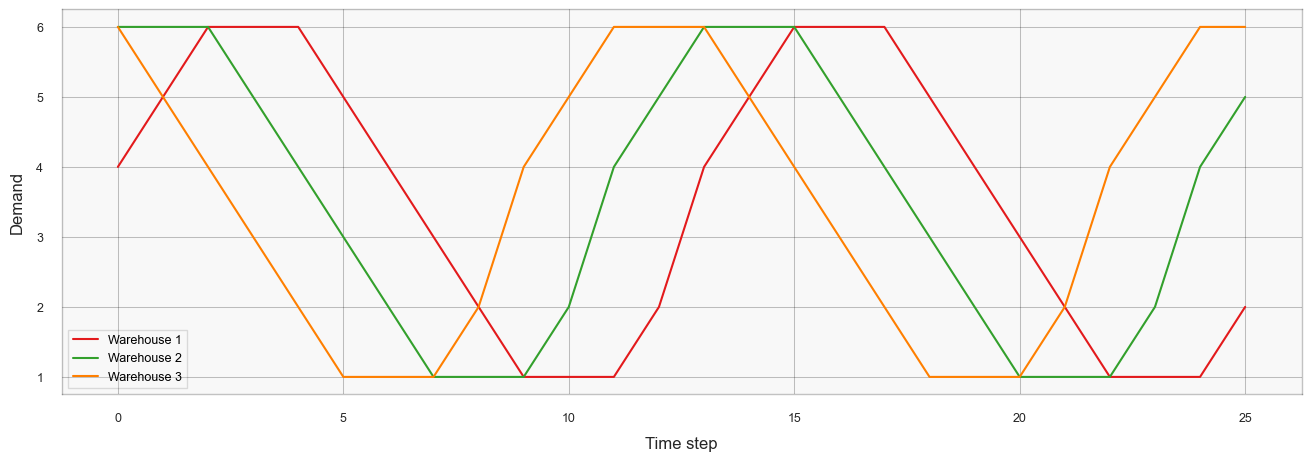

In [5]:
# visualize demand functions for warehouses
env = SupplyChainEnvironment()
demands = np.fromfunction(lambda j, t: env.demand(j, t), (env.warehouse_num, env.T), dtype=int)
plt.figure(figsize=(16, 5))
plt.xlabel("Time step")
plt.ylabel("Demand")
plt.plot(range(env.T), demands.T)
plt.legend([f'Warehouse {i+1}' for i in range(env.warehouse_num)])

# Common Functions and Visualization

In [6]:
def prepare_metric_plot(plots_n, n, ylabel):
    plt.subplot(plots_n, 1, n)
    plt.ylabel(ylabel)
    plt.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=False)

# visualizing one episode - stock levels, production and reorderign actions, and rewards
def visualize_transitions(transitions):
    state_trace, action_trace, reward_trace = (transitions.T[0], transitions.T[1], transitions.T[2])
    plots_n = 10
    mpl.rcParams['lines.linewidth'] = 2    
    print(f"Return is {sum(reward_trace)}")

    fig = plt.figure(figsize=(8, 12))
    prepare_metric_plot(plots_n, 1, "Stock,\n Factory")
    plt.plot(range(env.T), list(map(lambda s: s.factory_stock, state_trace)), c='purple', alpha=0.5)

    for w in range(env.warehouse_num):
        prepare_metric_plot(plots_n, 2 + w, f"Stock,\n WH {w+1}")
        plt.plot(range(env.T), list(map(lambda s: s.warehouse_stock[w], state_trace)), c='purple', alpha=0.5)
    
    prepare_metric_plot(plots_n, 5, "Production")
    plt.plot(range(env.T), list(map(lambda a: a.production_level, action_trace)), c='blue', alpha=0.5)

    for w in range(env.warehouse_num):
        prepare_metric_plot(plots_n, 6 + w, f"Shipment,\n WH {w+1}")
        plt.plot(range(env.T), list(map(lambda a: a.shippings_to_warehouses[w], action_trace)), c='blue', alpha=0.5)
    
    prepare_metric_plot(plots_n, 9, "Profit")
    plt.plot(range(env.T), reward_trace, c='red', alpha=0.9, linewidth=2)

    plt.subplot(plots_n, 1, 10)
    plt.ylabel("Cumulative\nprofit")
    plt.ylim(0, 10000)
    plt.plot(range(env.T), np.cumsum(reward_trace), c='red', alpha=0.9, linewidth=2)
    plt.xlabel("Time step")

# Baseline Policy - (s,Q)

In [7]:
# We use (s, Q)-policy as a baseline 
# The policy is: Order your Economic Order Quantity Q, every time your inventory 
# position drops below s (Reorder Point or Safety Stock).

class SQPolicy(object):
    def __init__(self, factory_safety_stock, factory_reorder_amount, safety_stock, reorder_amount):
        self.factory_safety_stock = factory_safety_stock
        self.factory_reorder_amount = factory_reorder_amount
        self.safety_stock = safety_stock
        self.reorder_amount = reorder_amount

    def select_action(self, state):
        action = Action(state.warehouse_num)
        for w in range(state.warehouse_num):
            if state.warehouse_stock[w] < self.safety_stock[w]:
                action.shippings_to_warehouses[w] = self.reorder_amount[w]
    
        if state.factory_stock - np.sum(action.shippings_to_warehouses) < self.factory_safety_stock: 
            action.production_level = self.factory_reorder_amount
        else: 
            action.production_level = 0
        return action
    
def simulate_episode(env, policy):
    state = env.initial_state()
    transitions = []
    for t in range(env.T):
        action = policy.select_action(state)
        state, reward, _ = env.step(state, action)
        transitions.append([state, action, reward])
    return transitions

# basic policy evaluation process 
def simulate(env, policy, num_episodes):
    returns_trace = []
    for episode in range(num_episodes):
        env.reset()
        returns_trace.append( sum(np.array(simulate_episode(env, policy)).T[2]) )
    return returns_trace

### Optimizing (s, Q)-policy parameters using Facebook Ax

In [8]:
from ax import optimize

def func(p):
    policy = SQPolicy(
        p['factory_s'], 
        p['factory_Q'],
        [ p['w1_s'], p['w2_s'], p['w3_s'], ],
        [ p['w1_Q'], p['w2_Q'], p['w3_Q'], ]
    )
    return np.mean(simulate(env, policy, num_episodes = 30))

best_parameters, best_values, experiment, model = optimize(
        parameters=[
          { "name": "factory_s",   "type": "range",  "bounds": [0.0, 30.0], },
          { "name": "factory_Q",   "type": "range",  "bounds": [0.0, 30.0], },
          { "name": "w1_s",        "type": "range",  "bounds": [0.0, 20.0], },
          { "name": "w1_Q",        "type": "range",  "bounds": [0.0, 20.0], },  
          { "name": "w2_s",        "type": "range",  "bounds": [0.0, 20.0], },
          { "name": "w2_Q",        "type": "range",  "bounds": [0.0, 20.0], },    
          { "name": "w3_s",        "type": "range",  "bounds": [0.0, 20.0], },
          { "name": "w3_Q",        "type": "range",  "bounds": [0.0, 20.0], },    
        ],
        evaluation_function=func,
        minimize=False,
        total_trials=2,
    )

[INFO 07-27 14:14:01] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter factory_s. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 07-27 14:14:01] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter factory_Q. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 07-27 14:14:01] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter w1_s. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 07-27 14:14:01] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter w1_Q. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parame

In [9]:
display(best_parameters)
display(best_values)

{'factory_s': 22.899096412584186,
 'factory_Q': 17.88985937833786,
 'w1_s': 10.750719420611858,
 'w1_Q': 2.6923635974526405,
 'w2_s': 1.0867617279291153,
 'w2_Q': 10.894683841615915,
 'w3_s': 1.365268100053072,
 'w3_Q': 15.93520749360323}

({'objective': -16174.514383242777}, {'objective': {'objective': nan}})

Reward: mean 7231.9, standard deviation 767.472807335869


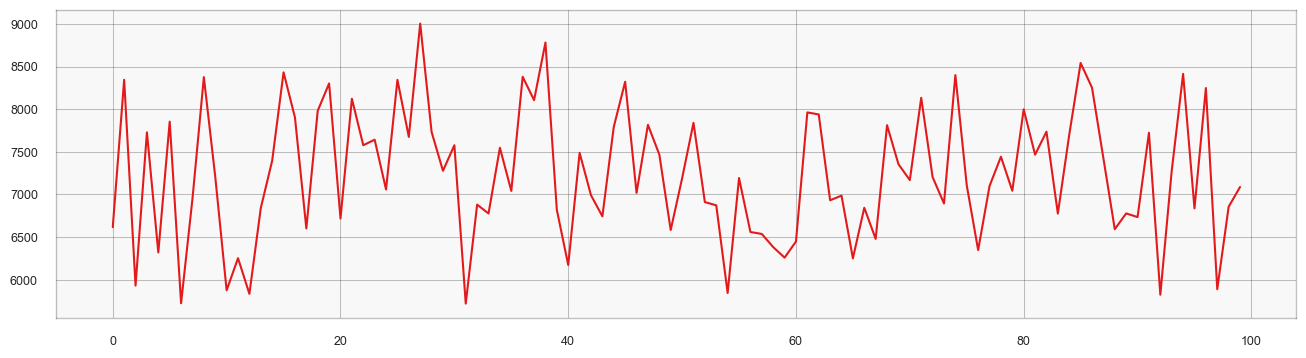

In [11]:
# evaluating the winning (s,Q) policy more accurately
env = SupplyChainEnvironment()
policy_sQ = SQPolicy(0.0, 20.0, [5, 5, 5], [5, 5, 10])
return_trace = simulate(env, policy_sQ, num_episodes = 100)
plt.figure(figsize=(16, 4))
plt.plot(range(len(return_trace)), return_trace)
print(f"Reward: mean {np.mean(return_trace)}, standard deviation {np.std(return_trace)}")

Return is 7757.0


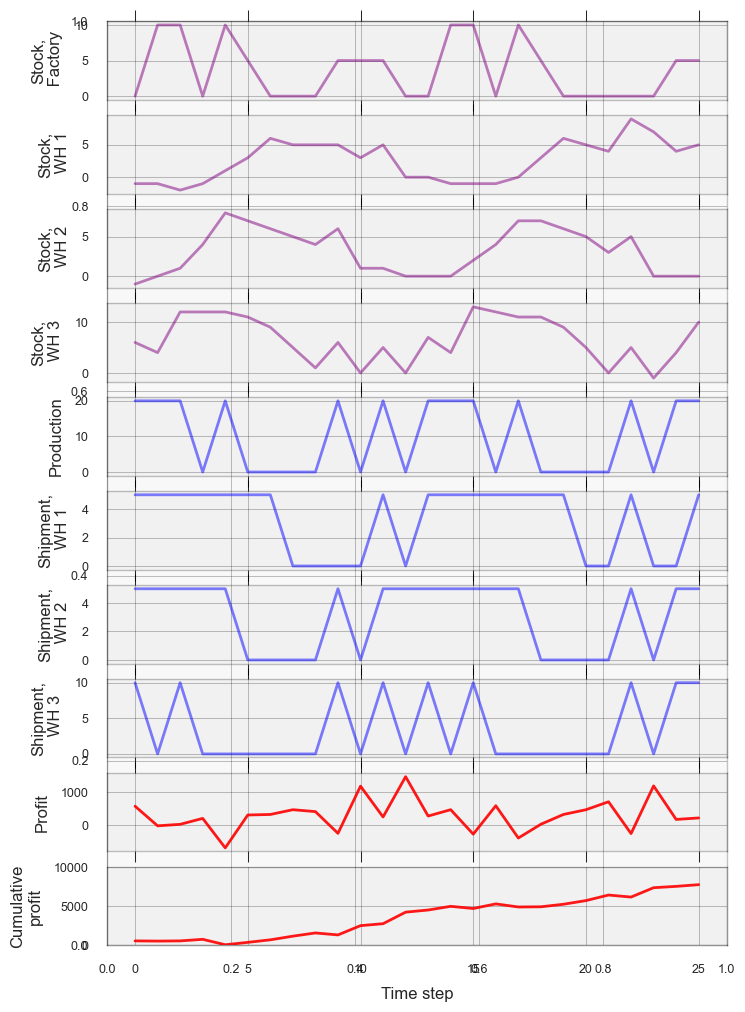

In [12]:
# tracing the winning (s,Q)  policy
env = SupplyChainEnvironment()
transitions_sQ = simulate_episode(env, policy_sQ)
visualize_transitions(np.array(transitions_sQ))

### Optimization of (s, Q)-policy parameters using brute force search

In [13]:
from sklearn.model_selection import ParameterGrid

p_grid1 = [5, 10, 20]
p_grid2 = [5, 10, 20]
param_grid = {
    'factory_s': p_grid1, 
    'factory_Q': p_grid1,
    'w1_s': p_grid2,
    'w2_s': p_grid2,
    'w3_s': p_grid2,
    'w1_Q': p_grid2,
    'w2_Q': p_grid2,
    'w3_Q': p_grid2,
    }

env = SupplyChainEnvironment()
grid = ParameterGrid(param_grid)
i = 0
best_return = float('-inf')
for p in grid:
    policy = SQPolicy(
        p['factory_s'], p['factory_Q'],
        [ p['w1_s'], p['w2_s'], p['w3_s'], ],
        [ p['w1_Q'], p['w2_Q'], p['w3_Q'], ]
    )
    m_return = np.mean(simulate(env, policy, num_episodes = 10))
    if m_return > best_return:
        best_return = m_return
        best_params = p

    if i % 100 == 0:
        print(f"Configuration #{i} -- {best_return}")
    i += 1

Configuration #0 -- -143913.6
Configuration #100 -- -143913.6
Configuration #200 -- -143913.6
Configuration #300 -- -143913.6
Configuration #400 -- -143913.6
Configuration #500 -- -143913.6
Configuration #600 -- -143913.6
Configuration #700 -- -143913.6
Configuration #800 -- -138913.3
Configuration #900 -- -138913.3
Configuration #1000 -- -138913.3
Configuration #1100 -- -138913.3
Configuration #1200 -- -138913.3
Configuration #1300 -- -138913.3
Configuration #1400 -- -138913.3
Configuration #1500 -- -137785.0
Configuration #1600 -- -137785.0
Configuration #1700 -- -137785.0
Configuration #1800 -- -137785.0
Configuration #1900 -- -137785.0
Configuration #2000 -- -137785.0
Configuration #2100 -- -137785.0
Configuration #2200 -- -2085.7
Configuration #2300 -- -2085.7
Configuration #2400 -- -2085.7
Configuration #2500 -- -2085.7
Configuration #2600 -- -2085.7
Configuration #2700 -- -2085.7
Configuration #2800 -- -2085.7
Configuration #2900 -- -2085.7
Configuration #3000 -- -1987.3
Configu

# Optimizing the Policy Using Reinforcement Learning / RLlib

In [18]:
import argparse

from rllib_ddpg.ddpg import DDPG, DDPGConfig
import ray
from ray import air, tune
from ray.rllib.utils.test_utils import check_learning_achieved
import numpy as np
import gymnasium as gym
from gymnasium.spaces import Box
from gymnasium.wrappers import EnvCompatibility
import ray
from ray import tune
from ray.rllib.utils import try_import_tf
from ray.tune.logger import pretty_print
from ray.tune.registry import register_env

tf = try_import_tf()

# gym environment adapter
class SimpleSupplyChain(gym.Env):
    def __init__(self, config):
        self.reset()
        self.action_space = Box(low=0.0, high=20.0, shape=(self.supply_chain.warehouse_num + 1, ), dtype=np.int16)
        self.observation_space = Box(-10000, 10000, shape=(len(self.supply_chain.initial_state().to_array()), ), dtype=np.float32)

    def reset(self, *, seed=None, options=None):
        self.supply_chain = SupplyChainEnvironment()
        self.state = self.supply_chain.initial_state()
        return self.state.to_array(), {}

    def step(self, action):
        action_obj = Action(self.supply_chain.warehouse_num)
        action_obj.production_level = action[0]
        action_obj.shippings_to_warehouses = action[1:]
        self.state, reward, done = self.supply_chain.step(self.state, action_obj)
        return self.state.to_array(), reward, False, done, {}

ray.shutdown()
ray.init()

def train_ddpg():
    algo = (
      DDPGConfig()
      .rollouts(num_rollout_workers=1)
      .resources(num_gpus=0)
      .training(gamma=0.95, 
                actor_hiddens=[512, 512], 
                critic_hiddens=[512, 512],
                target_network_update_freq=5)

      .environment(env=SimpleSupplyChain)
      .build()
    )
    #config = ddpg.DEFAULT_CONFIG.copy()
    #algo["log_level"] = "WARN"
    #algo["actor_hiddens"] = [512, 512] 
    #algo["critic_hiddens"] = [512, 512]
    #algo["gamma"] = 0.95
    #algo["timesteps_per_iteration"] = 1000
    #algo["target_network_update_freq"] = 5
    #algo["buffer_size"] = 10000
    
    for i in range(2):
        print(i)
        result = algo.train()
        print(pretty_print(result))
        checkpoint_dir = algo.save()
        print("Checkpoint saved at", checkpoint_dir)
    return checkpoint_dir


checkpoint_dir=train_ddpg()
checkpoint_dir=checkpoint_dir[:-18]

2024-07-27 14:57:35,629	INFO worker.py:1636 -- Started a local Ray instance.
(RolloutWorker pid=34824) 2024-07-27 14:57:46,965	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.


0
agent_timesteps_total: 1000
connector_metrics:
  ObsPreprocessorConnector_ms: 0.001379251480102539
  StateBufferConnector_ms: 0.0018066167831420898
  ViewRequirementAgentConnector_ms: 0.11840224266052246
counters:
  num_agent_steps_sampled: 1000
  num_agent_steps_trained: 0
  num_env_steps_sampled: 1000
  num_env_steps_trained: 0
custom_metrics: {}
date: 2024-07-27_14-57-53
done: false
episode_len_mean: 25.0
episode_media: {}
episode_reward_max: -321401.0
episode_reward_mean: -620053.175
episode_reward_min: -844512.0
episodes_this_iter: 40
episodes_total: 40
hostname: MSI
info:
  learner: {}
  num_agent_steps_sampled: 1000
  num_agent_steps_trained: 0
  num_env_steps_sampled: 1000
  num_env_steps_trained: 0
iterations_since_restore: 1
node_ip: 127.0.0.1
num_agent_steps_sampled: 1000
num_agent_steps_trained: 0
num_env_steps_sampled: 1000
num_env_steps_sampled_this_iter: 1000
num_env_steps_sampled_throughput_per_sec: 170.82780477581025
num_env_steps_trained: 0
num_env_steps_trained_thi

# Analysis and Debugging of the Policy Produced by RLlib

In [15]:
%ls -la /root/ray_results/DDPG_SimpleSupplyChain_2023-04-28_13-48-214c5hqra0/checkpoint_000002

Le format du param�tre est incorrect - "root".


In [20]:
import json
# checkpoint_dir = cwd+'/ray_results/DDPG_SimpleSupplyChain_test/'
algo = (
  DDPGConfig()
  .rollouts(num_rollout_workers=1)
  .resources(num_gpus=0)
  .training(gamma=0.95, 
            actor_hiddens=[512, 512], 
            critic_hiddens=[512, 512],
            target_network_update_freq=5)

  .environment(env=SimpleSupplyChain)
  .build()
)

def load_policy():
    log_dir = checkpoint_dir # this path can be changed manually, by default should be the last checkpoint_dir set in the cell above. 
    checkpoint_id = "000002"
    algo.restore(f"{log_dir}/checkpoint_{checkpoint_id}/")
    return algo.get_policy()

policy = load_policy()

# tracing the policy
env = SupplyChainEnvironment()
state = env.initial_state()
transitions_rl = []
for t in range(env.T):
    action = policy.compute_single_action( state.to_array() , state=[] ) 
    action_obj = Action(env.warehouse_num)
    action_obj.production_level = action[0][0]
    action_obj.shippings_to_warehouses = action[0][1:]
    state, reward, _ = env.step(state, action_obj)
    transitions_rl.append([state, action_obj, reward])

2024-07-27 15:01:52,634	INFO trainable.py:918 -- Restored on 127.0.0.1 from checkpoint: C:\Users\germa\ray_results\DDPG_SimpleSupplyChain_2024-07-27_14-57-39ec2z9gwx\checkpoint_000002
2024-07-27 15:01:52,634	INFO trainable.py:927 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 39.25529766082764, '_episodes_total': 80}


Return is -801109.2510982477


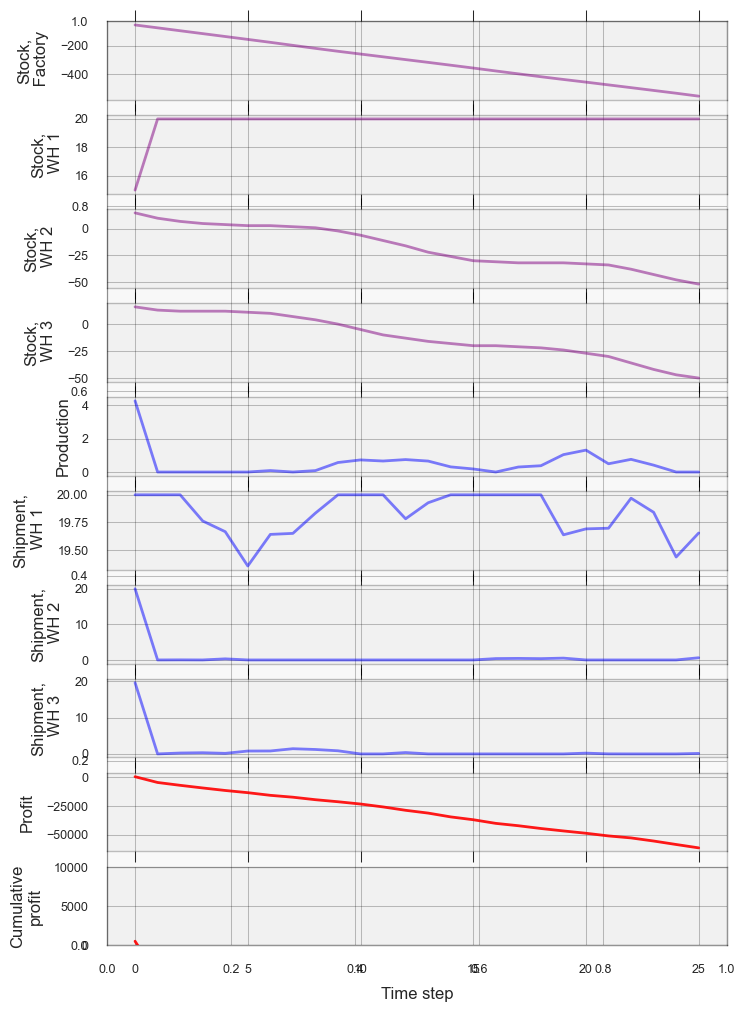

In [21]:
# tracing the policy
visualize_transitions(np.array(transitions_rl))